### Import

In [ ]:
import os, gc, warnings, random, math
import datetime
from datetime import timedelta
from joblib import Parallel, delayed
import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import copy

warnings.filterwarnings('ignore')

from random import seed

from tensorflow.keras import backend as K
from tensorflow.keras import initializers

import pandas as pd
import numpy as np
import operator
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

!pip install yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import silhouette_samples

import itertools
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Настройки визуализации
%matplotlib inline
plt.style.use('ggplot')
sns.set(style='whitegrid')
sns.set_context('paper')
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40

## Определение функций

In [ ]:
pass

## Основные параметры модуля

In [ ]:
DATA_PATH = '../data/'
PNG_PATH = '../png/'
PREPROCESSED_DATA_PATH = '../preprocessed data/'

## Построение данных для кластеризации

### Получение данных

In [ ]:
df_svista = pd.read_csv(f'{PREPROCESSED_DATA_PATH}prep_data.csv')
df_svista

In [ ]:
print('Кол-во исходных признаков:', len(df_svista.columns))
print(list(df_svista.columns))
print(df_svista.info())
for column in df_svista.columns:
  print(eval("83*'_'"),'\n',"Column: ", column,"  Num of unique: ", len(df_svista[column].unique()), '\n', "Unique data:", df_svista[column].unique()[:5], sep='')

### Построение признаков

In [ ]:
df_sv_card = {}
#Построение словаря содержащего транзакции по отдельным картам
for i in tqdm(df_svista['CARDID_NUM'].unique()):
  df_sv_card[i]=df_svista[df_svista['CARDID_NUM']==i]
  #df_sv_card[i].drop(columns=['CARDID','CARDID_NUM','COUNT_OF_TRANSACTIONS'],inplace=True)
  df_sv_card[i] = df_sv_card[i].sort_values(['DATE_TIME_SEC'])
  df_sv_card[i].reset_index(drop=True, inplace=True)
  # Удаляем признаки с одним значением по каждой карте
  for j in df_sv_card[i].columns:
    if len(df_sv_card[i][j].unique())==1:
      df_sv_card[i].drop(columns=[j],inplace=True)
  # Приводим время по каждой карте к отсчету от первой транзакции
  min_time = df_sv_card[i]['DATE_TIME_SEC'].min()
  df_sv_card[i]['DATE_TIME_SEC'] = df_sv_card[i]['DATE_TIME_SEC'] - min_time

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:02<00:00, 88.75it/s]


In [ ]:
features_per_card = []
mean_per_day = []
mean_per_hour = []
var_hour = []
var_day = []

for i in df_sv_card.keys():
  features_per_card.append([i,len(df_sv_card[i].columns)])
  
  minutes = df_sv_card[i]['DATE_TIME_SEC']/60
  minutes = minutes.astype(int)
  df_sv_card[i]['Minutes']=minutes
  hours = ((df_sv_card[i]['Minutes']/60)) % 24
  hours = hours.astype(int)
  df_sv_card[i]['Hours'] = hours

  DAY = (df_sv_card[i]['DATE_TIME_SEC']/86400)
  DAY = DAY.astype(int)
  df_sv_card[i]['DAY']=DAY

  mean_per_day.append(df_sv_card[i]['DAY'].mean())
  mean_per_hour.append(df_sv_card[i]['Hours'].mean())
  var_hour.append(np.var(df_sv_card[i]['Hours']))
  var_day.append(np.var(df_sv_card[i]['DAY']))


In [ ]:
len(var_hour)

187

In [ ]:
df_claster = pd.DataFrame({'CARDID_NUM':list(df_svista['CARDID_NUM'].unique()),
                           'COUNT_OF_TRANSACTIONS':list(df_svista.groupby('CARDID_NUM')['AMOUNT'].agg('count')),
                           'MCC_NUNIQUE':list(df_svista.groupby('CARDID_NUM')['MCC_freq'].nunique()),
                           'COUNTRY_NUNIQUE':list(df_svista.groupby('CARDID_NUM')['MERCH_COUNTRY_freq'].nunique()),
                           'CITY_NUNIQUE':list(df_svista.groupby('CARDID_NUM')['MERCH_CITY_freq'].nunique()),
                           'TERMINAL_NUNIQUE':list(df_svista.groupby('CARDID_NUM')['TERMINAL_ID_freq'].nunique()),
                           'TRANS_TYPE_NUNIQUE':list(df_svista.groupby('CARDID_NUM')['TRANS_TYPE_freq'].nunique()),
                           'TIME_WINDOW':list(df_svista.groupby('CARDID_NUM')['DATE_TIME_SEC'].max()-df_svista.groupby('CARDID_NUM')['DATE_TIME_SEC'].min()),
                           'MEAN_TIME_DIFF':list(df_svista.groupby('CARDID_NUM')['TIME_DIFF'].mean()),
                           'UNIQUE_FEATURES':list(np.array(features_per_card)[:,1]),
                           'MEAN_PER_DAY':list(mean_per_day),
                           'MEAN_PER_HOUR':list(mean_per_hour),
                           'VAR_DAY':list(var_day),
                           'VAR_HOUR':list(var_hour)
                           })

In [ ]:
df_claster = pd.DataFrame({'CARDID_NUM':list(df_svista['CARDID_NUM'].unique()),
                           'COUNT_OF_TRANSACTIONS':list(df_svista.groupby('CARDID_NUM')['AMOUNT'].agg('count')),
                           'MCC_NUNIQUE':list(df_svista.groupby('CARDID_NUM')['MCC_freq'].nunique()),
                           'TRANS_TYPE_NUNIQUE':list(df_svista.groupby('CARDID_NUM')['TRANS_TYPE_freq'].nunique())
                           })

In [ ]:
df_claster = pd.DataFrame({'CARDID_NUM':list(df_svista['CARDID_NUM'].unique()),
                           'COUNT_OF_TRANSACTIONS':list(df_svista.groupby('CARDID_NUM')['AMOUNT'].agg('count')),
                           'MCC_NUNIQUE':list(df_svista.groupby('CARDID_NUM')['MCC_freq'].nunique()),
                           #'COUNTRY_NUNIQUE':list(df_svista.groupby('CARDID_NUM')['MERCH_COUNTRY_freq'].nunique()),
                           #'CITY_NUNIQUE':list(df_svista.groupby('CARDID_NUM')['MERCH_CITY_freq'].nunique()),
                           'TERMINAL_NUNIQUE':list(df_svista.groupby('CARDID_NUM')['TERMINAL_ID_freq'].nunique()),
                           'TRANS_TYPE_NUNIQUE':list(df_svista.groupby('CARDID_NUM')['TRANS_TYPE_freq'].nunique()),
                           'TIME_WINDOW':list(df_svista.groupby('CARDID_NUM')['DATE_TIME_SEC'].max()-df_svista.groupby('CARDID_NUM')['DATE_TIME_SEC'].min()),
                           'MEAN_TIME_DIFF':list(df_svista.groupby('CARDID_NUM')['TIME_DIFF'].mean()),
                           'UNIQUE_FEATURES':list(np.array(features_per_card)[:,1]),
                           #'AMOUNT_MAX':list(df_svista.groupby('CARDID_NUM')['AMOUNT'].max()),
                           #'AMOUNT_MIN':list(df_svista.groupby('CARDID_NUM')['AMOUNT'].min()),
                           #'AMOUNT_MEAN':list(df_svista.groupby('CARDID_NUM')['AMOUNT'].mean()),
                           #'MEAN_PER_DAY':list(mean_per_day),
                           #'MEAN_PER_HOUR':list(mean_per_hour),
                           #'VAR_DAY':list(var_day),
                           #'VAR_HOUR':list(var_hour)
                           })

In [ ]:
df_claster

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_claster, figsize=(15,15));

## Кластеризация

### Оценка качества кластеризации, выбор количества кластеров

In [ ]:
df_claster.columns

Index(['CARDID_NUM', 'COUNT_OF_TRANSACTIONS', 'MCC_NUNIQUE',
       'TERMINAL_NUNIQUE', 'TRANS_TYPE_NUNIQUE', 'TIME_WINDOW',
       'MEAN_TIME_DIFF', 'UNIQUE_FEATURES'],
      dtype='object')

In [ ]:
def X_builder(df_claster, PCA_bool=True):
  X = df_claster.iloc[:,1:].values
  X_norm = (X-X.mean(axis=0))/X.std(axis=0)
  if PCA_bool:
    print('До понижения размерности', X_norm.shape)
    pca = PCA(n_components=2)
    X_norm = pca.fit_transform(X_norm)
    print(pca.explained_variance_ratio_)
    print('После понижения размерности',X_norm.shape)
  else:
    print(X_norm.shape)
  return X_norm
X = df_claster.iloc[:,1:].values
X_norm = X_builder(df_claster,False)

(187, 7)


In [ ]:
### Проверка на метод локтя
kmin = 1
kmax = 30
scores = []

for k in tqdm(range(kmin,kmax)):
  kmeans = KMeans(n_clusters=k, random_state=123)
  kmeans.fit(X_norm)
  scores.append(kmeans.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  9.07it/s]


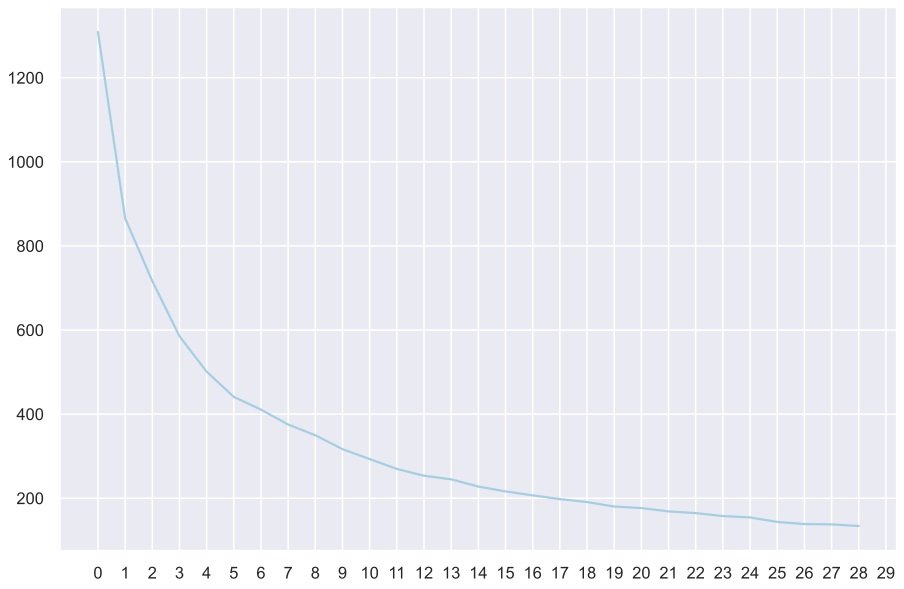

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(15,10))
plt.xticks(list(range(30)))
plt.plot(scores)
if not os.path.isfile(f'{PNG_PATH}/elbow_method.png'):
  plt.savefig(f'{PNG_PATH}/elbow_method', dpi=300)

In [ ]:
X.shape

(187, 7)

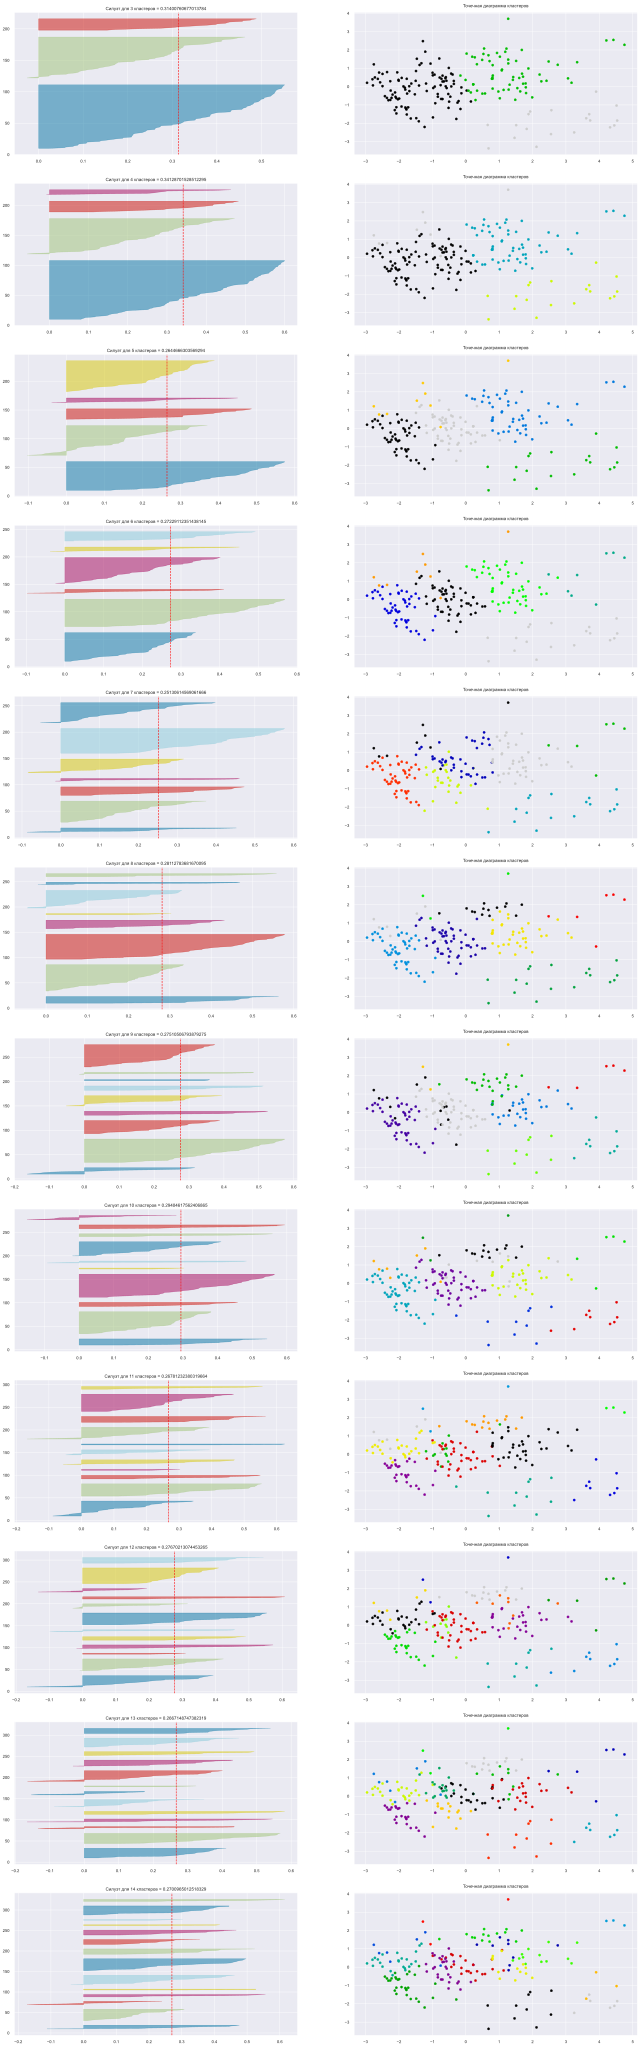

In [ ]:
### Метод силуэта
list_klusters = list(range(3,15))
f = plt.figure(figsize=(30,100))
sns.set(style="darkgrid")
gs = f.add_gridspec(math.ceil(len(list_klusters)), 2)
for i,j in enumerate(list_klusters):
  kmeans = KMeans(n_clusters=j, random_state=123)
  preds = kmeans.fit_predict(X_norm)
  score = silhouette_score(X_norm, preds)
  centroids = np.array(kmeans.cluster_centers_)

  visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
  ax = f.add_subplot(gs[(int) (i), 0])
  ax.set_title(f"Силуэт для {j} кластеров = {score}")
  visualizer.fit(X_norm)

  sns.set_theme(palette="Paired")
  ax = f.add_subplot(gs[(int) (i), 1])
  
  pca = PCA(n_components=2, random_state=123)
  X_visual = pca.fit_transform(X_norm)
  centroids_v = np.array(kmeans.cluster_centers_)
  plt.scatter(X_visual[:,0],X_visual[:,1], c = preds, cmap=plt.cm.nipy_spectral)
  #plt.scatter(centroids[:,0],centroids[:,1], marker = '*' , c= 'r',s =250)
  plt.title('Точечная диаграмма кластеров', y=1.02)
plt.show()


In [ ]:
if not os.path.isfile(f'{PNG_PATH}/silhouette_scatter_for_clusters.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/silhouette_scatter_for_clusters', dpi=300)

### Финальный результат и интерпретация

In [ ]:
# Финальный результат
df_claster_test = df_claster.copy(deep=True)
kmeans = KMeans(n_clusters=4, random_state=123)
preds = kmeans.fit_predict(X_norm)
centroids = np.array(kmeans.cluster_centers_)
df_claster_test['labels_PCA'] = kmeans.labels_
df_claster_test.groupby('labels_PCA')['CARDID_NUM'].agg('count')

labels_PCA
0    99
1    60
2    19
3     9
Name: CARDID_NUM, dtype: int64

In [ ]:
for i in df_claster_test['labels_PCA'].unique():

  print(f'Для калстера {i}','\n',
        'Минимальная история:  ', df_claster_test[df_claster_test['labels_PCA']==i]['COUNT_OF_TRANSACTIONS'].min(),'\n',
        'Максимальная история: ', df_claster_test[df_claster_test['labels_PCA']==i]['COUNT_OF_TRANSACTIONS'].max(),'\n',
        'Средняя история:      ', df_claster_test[df_claster_test['labels_PCA']==i]['COUNT_OF_TRANSACTIONS'].mean(),'\n',
        'Медианная история:    ', df_claster_test[df_claster_test['labels_PCA']==i]['COUNT_OF_TRANSACTIONS'].median(),'\n',
        sep='')

Для калстера 3
Минимальная история:  151
Максимальная история: 323
Средняя история:      219.33333333333334
Медианная история:    185.0

Для калстера 0
Минимальная история:  20
Максимальная история: 117
Средняя история:      36.505050505050505
Медианная история:    30.0

Для калстера 1
Минимальная история:  20
Максимальная история: 116
Средняя история:      38.03333333333333
Медианная история:    29.0

Для калстера 2
Минимальная история:  20
Максимальная история: 43
Средняя история:      25.526315789473685
Медианная история:    23.0



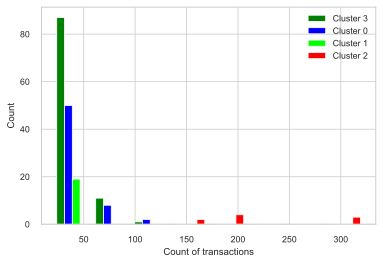

In [ ]:
x1 = df_claster_test[df_claster_test['labels_PCA']==0]['COUNT_OF_TRANSACTIONS']
x2 = df_claster_test[df_claster_test['labels_PCA']==1]['COUNT_OF_TRANSACTIONS']
x3 = df_claster_test[df_claster_test['labels_PCA']==2]['COUNT_OF_TRANSACTIONS']
x4 = df_claster_test[df_claster_test['labels_PCA']==3]['COUNT_OF_TRANSACTIONS']

n_bins = 8
colors = ['green', 'blue', 'lime', 'red']

plt.hist([x1,x2,x3,x4], n_bins, density = False, 
         histtype ='bar',
         color = colors)

plt.legend(['Cluster '+str(e) for e in list(df_claster_test['labels_PCA'].unique())])
plt.xlabel('Count of transactions')
plt.ylabel('Count')
if not os.path.isfile(f'{PNG_PATH}/card_per_cluster.png'):
  plt.savefig(f'{PNG_PATH}/card_per_cluster', dpi=300)  
plt.show()     

In [ ]:
df_claster_test[(df_claster_test['labels_PCA']==2)]

## Сохранение результатов

In [ ]:
if not os.path.isfile(f'{PREPROCESSED_DATA_PATH}data_clusters.csv'):
  df_claster_test[['CARDID_NUM','labels_PCA']].to_csv(f'{PREPROCESSED_DATA_PATH}data_clusters.csv', index=False)